In [96]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import ParameterGrid
from metrics import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # Suppress the warning


In [97]:
# Loading the datasets
train_data = pd.read_parquet("train_dataset_ebnerd_small.parquet")
validation_data = pd.read_parquet("val_dataset_ebnerd_small.parquet")
test_data = pd.read_parquet("test_dataset_ebnerd_small.parquet")

# Displaying dataset sizes
print(f"Training data size: {len(train_data):,} samples")
print(f"Validation data size: {len(validation_data):,} samples")
print(f"Test data size: {len(test_data):,} samples")





Training data size: 1,882,518 samples
Validation data size: 343,776 samples
Test data size: 359,446 samples


In [98]:
import pandas as pd
import xgboost as xgb

# Assuming train_data, validation_data, and test_data are your DataFrames
target = ["clicked"]
ids = ["impression_id", "session_id", "article_id", "user_id"]
excluded_columns = target + ids

# Step 1: Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
feature_list = [col for col in train_data.columns if col not in excluded_columns]

# Step 2: Combine feature_list with categorical_columns to ensure we're encoding them correctly
feature_list = list(set(feature_list + categorical_columns))
print("Features used for modeling:", feature_list)

# Prepare training data
X_train = pd.get_dummies(train_data[feature_list], drop_first=True)
y_train = train_data['clicked'].values
X_train['qid'] = train_data['impression_id'] 

# Prepare validation data
X_val = pd.get_dummies(validation_data[feature_list], drop_first=True)
X_val = X_val.reindex(columns=X_train.columns[:-1], fill_value=0) 
y_val = validation_data['clicked'].values
X_val['qid'] = validation_data['impression_id'] 
# Prepare test data
X_test = pd.get_dummies(test_data[feature_list], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns[:-1], fill_value=0)  
y_test = test_data['clicked'].values
X_test['qid'] = test_data['impression_id']

dtrain = xgb.DMatrix(X_train.drop(columns=['qid']), label=y_train, qid=X_train['qid'])
dval = xgb.DMatrix(X_val.drop(columns=['qid']), label=y_val, qid=X_val['qid'])
dtest = xgb.DMatrix(X_test.drop(columns=['qid']), label=y_test, qid=X_test['qid'])


Features used for modeling: ['is_subscriber', 'origin_current_diff_published', 'user_article_least_favorite', 'is_sso_user', 'sentiment_label', 'user_article_same_mood', 'cluster', 'origin_sentiment_score', 'device_type', 'origin_current_diff_sentiment_score', 'user_average_scroll_percentage', 'user_average_read_time', 'coming_from_home_page', 'origin_current_same_sentiment_label', 'origin_current_diff_impression_published', 'user_article_favorite', 'user_mood', 'user_impression_frequency', 'time_of_day', 'origin_scroll_percentage', 'origin_read_time', 'origin_current_same_cluster', 'user_interaction_score', 'origin_cluster', 'origin_current_same_category', 'sentiment_score', 'origin_sentiment_label', 'premium']


In [ ]:
# Custom function to calculate NDCG for each group
def calculate_grouped_ndcg(df, k=3, id = "impression_id"):
    ndcg_scores = []
    for qid, group in df.groupby(id):
        ndcg_scores.append(calculate_ndcg(group, k))
    return np.mean(ndcg_scores)

In [ ]:
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
from tqdm import tqdm

# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Tracking the best and worst model scores and parameters
best_score = -float('inf')
worst_score = float('inf')
best_params = None

early_stopping_rounds = 10
stop_after = 1000
iterations = 0

# Initialize tqdm with the description placeholder
with tqdm(ParameterGrid(param_grid), desc="Best NDCG@3: N/A, Worst NDCG@3: N/A, Diff: N/A") as pbar:
    for params in pbar:
        iterations += 1
        model = xgb.train(
            params={
                'objective': 'rank:ndcg',
                'lambdarank_num_pair_per_sample': '3',  # Specify ndcg@3 as our objective function
                'eval_metric': 'ndcg@3',  # Evaluation ranking for early stopping
                **params
            },
            dtrain=dtrain,
            num_boost_round=500, 
            evals=[(dval, 'validation')], 
            early_stopping_rounds=early_stopping_rounds,  # stops if no improvement after 10 rounds
            verbose_eval=False  
        )
        
        y_pred_valid = model.predict(dval)
        validation_data.loc[:, 'predicted_score'] = y_pred_valid
        ndcg_score = calculate_grouped_ndcg(validation_data, k=3)  # Custom function for NDCG
        
        # Update the best score and parameters if the current score is higher
        if ndcg_score > best_score:
            best_score = ndcg_score
            best_params = params
        
        # Update the worst score if the current score is lower
        if ndcg_score < worst_score:
            worst_score = ndcg_score

        # Calculate the difference between best and worst score
        diff_score = best_score - worst_score

        # Update the tqdm description with the best, worst, and diff scores
        pbar.set_description(f"Best NDCG@3: {best_score:.4f}, Worst NDCG@3: {worst_score:.4f}, Diff: {diff_score:.4f}")

        if iterations > stop_after:
            print("Testing done")
            break

print("Best Parameters:", best_params)
print("Best Validation NDCG@3:", best_score)
print("Worst Validation NDCG@3:", worst_score)
print("Difference between Best and Worst NDCG@3:", best_score - worst_score)


Best NDCG@3: 0.4359:   1%|▏         | 1/72 [00:38<45:34, 38.51s/it]


KeyboardInterrupt: 

In [ ]:
# Step 1: Combine train and validation data
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val])
qid_combined = pd.concat([train_data['impression_id'], validation_data['impression_id']], axis=0)

# Step 2: Create DMatrix with qid for combined data
dcombined = xgb.DMatrix(X_combined, label=y_combined)
dcombined.set_group(qid_combined.groupby(qid_combined).size().to_list())  # Set qid as group size list

# Step 3: Train final model with best hyperparameters on combined data
final_model = xgb.train(
    params={
        'objective': 'rank:pairwise',
        'eval_metric': 'ndcg',
        **best_params
    },
    dtrain=dcombined,
    num_boost_round=200,  # Set a high number for best result
    verbose_eval=True
)

# Step 4: Generate predictions on test data using DMatrix
dtest = xgb.DMatrix(X_test)
y_pred_test = final_model.predict(dtest)

# Optionally add predictions to test DataFrame
test_data['predicted_score'] = y_pred_test

# Output the predictions
print(test_data[['impression_id', 'predicted_score']])

        impression_id  predicted_score
0              149474         0.036988
1              149474        -0.033353
2              149474         0.354306
3              149474         0.432995
4              149474        -0.169286
...               ...              ...
359441      579756177         0.121783
359442      579756177         0.149219
359443      579756177         0.104029
359444      579756177         0.125771
359445      579756177         0.279272

[359446 rows x 2 columns]


In [ ]:
# Get feature importance from the trained model
feature_importance = final_model.get_fscore()

# Convert the dictionary to a pandas DataFrame for easier manipulation
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Get the top 10 important features
importance_df.head(10)

,Feature,Importance
1,origin_current_diff_published,1709.0
17,origin_read_time,1170.0
22,sentiment_score,746.0
23,premium,733.0
8,origin_current_diff_sentiment_score,511.0
14,user_article_favorite,483.0
7,device_type,441.0
5,cluster,252.0
11,coming_from_home_page,195.0
13,origin_current_diff_impression_published,159.0


In [ ]:
# Sort articles by predicted score within each session
test_data = test_data.sort_values(by=['impression_id', 'predicted_score'], ascending=[True, False])

# Display the ranked articles
print(test_data[['impression_id', 'article_id','clicked', 'predicted_score']])

        impression_id  article_id  clicked  predicted_score
3              149474     9778657     True         0.432995
2              149474     9778669    False         0.354306
0              149474     9778623    False         0.036988
1              149474     9778682    False        -0.033353
4              149474     9778736    False        -0.169286
...               ...         ...      ...              ...
359441      579756177     9778827     True         0.121783
359443      579756177     9778219    False         0.104029
359439      579756177     9778722    False         0.068023
359438      579756177     9778917    False         0.044722
359440      579756177     9220931    False        -1.002620

[359446 rows x 4 columns]


In [ ]:
results = test_data.groupby('impression_id', group_keys=False).apply(lambda x: pd.Series({
    'AUC': calculate_auc(x),
    'MRR': calculate_mrr(x),
    'NDCG@3': calculate_ndcg(x, 3),
    'NDCG@5': calculate_ndcg(x, 5),
    'NDCG@10': calculate_ndcg(x, 10),
    
}))
# WHY IS THIS SO SLOW?
print(results) 


                    AUC       MRR   NDCG@3    NDCG@5   NDCG@10
impression_id                                                 
149474         1.000000  1.000000  1.00000  1.000000  1.000000
150528         0.750000  0.333333  0.50000  0.500000  0.500000
153068         0.833333  0.500000  0.63093  0.630930  0.630930
153070         1.000000  1.000000  1.00000  1.000000  1.000000
153071         1.000000  1.000000  1.00000  1.000000  1.000000
...                 ...       ...      ...       ...       ...
579752481      0.800000  0.500000  0.63093  0.630930  0.630930
579752593      0.500000  0.333333  0.50000  0.500000  0.500000
579755467      0.545455  0.166667  0.00000  0.000000  0.356207
579755468      0.857143  0.500000  0.63093  0.630930  0.630930
579756177      0.571429  0.250000  0.00000  0.430677  0.430677

[32558 rows x 5 columns]


/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_63516/1132052872.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = test_data.groupby('impression_id', group_keys=False).apply(lambda x: pd.Series({


In [ ]:
results.mean()

AUC        0.719772
MRR        0.489135
NDCG@3     0.472109
NDCG@5     0.552287
NDCG@10    0.599231
dtype: float64

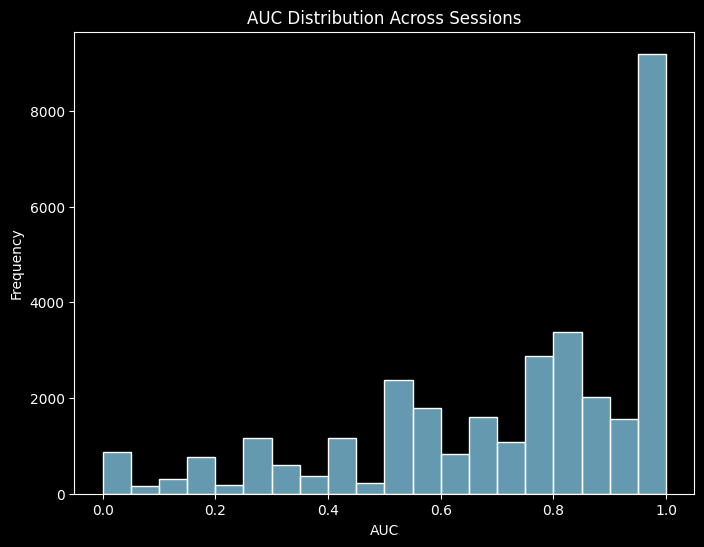

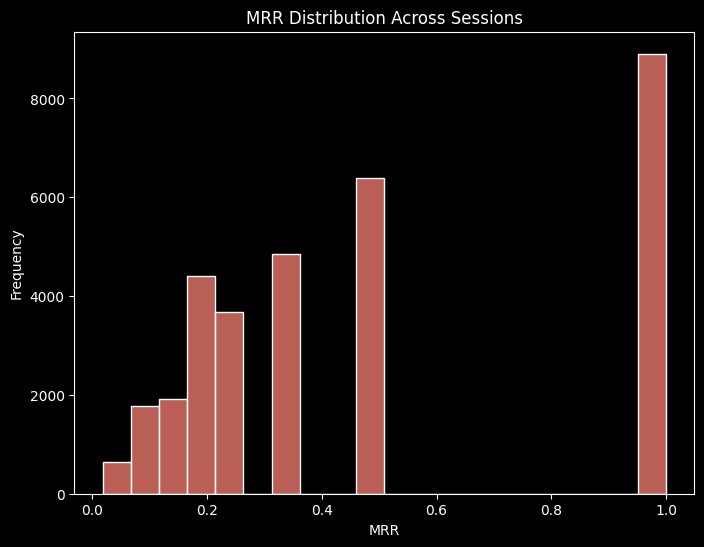

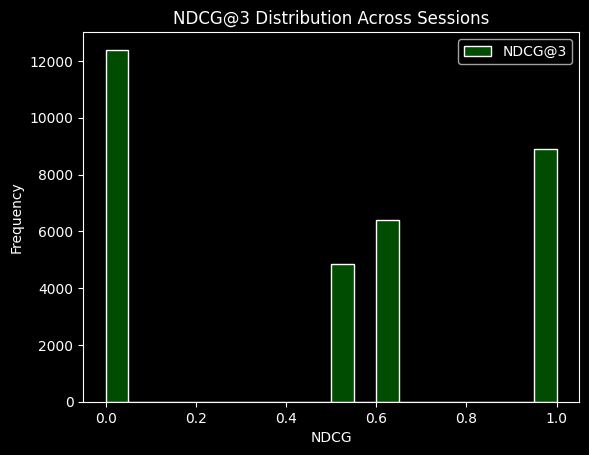

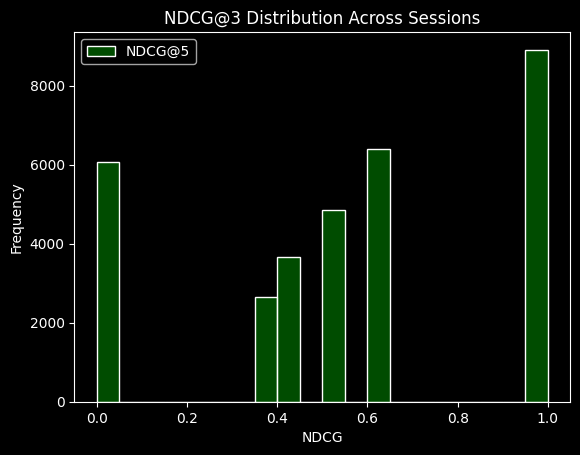

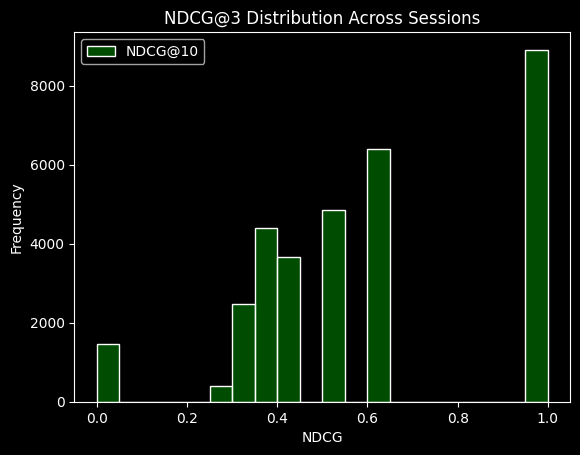

In [ ]:

bins = 20
# Plot 2: AUC Distribution Across Sessions
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=False, color="skyblue", bins=bins)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.show()

# Plot 3: MRR Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=False, color="salmon", bins=bins)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.show()

# Plot 4: NDCG@3 
sns.histplot(results['NDCG@3'], kde=False, color="green", label="NDCG@3", bins=bins, alpha=0.6)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Plot 5: NDCG@5 
sns.histplot(results['NDCG@5'], kde=False, color="green", label="NDCG@5", bins=bins, alpha=0.6)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot 6: NDCG@10 
sns.histplot(results['NDCG@10'], kde=False, color="green", label="NDCG@10", bins=bins, alpha=0.6)
plt.title("NDCG@3 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()




